# Main script to Join Data on Instrument 2 Fire Location

Modules: N/A <br>
Author: Jordan Meyer <br>
Email: jordan.meyer@berkeley.edu <br>
Date created: Feb 18, 2023 <br>

**Citations (data sources)**


**Citations (persons)**
1. Cornelia Ilin 

**Preferred environment**
1. Code written in Jupyter Notebooks

In [15]:
import sys

IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    !pip install geopandas --quiet
    from google.colab import drive

    drive.mount("/content/drive")
    in_dir = (
        in_instrument
    ) = "/content/drive/MyDrive/capstone_fire/notebooks/Baseline_Regression/"
    import drive.MyDrive.capstone_fire.modules.deep_ols as deep_ols
else:
    in_dir = in_instrument = "./../"
    %cd '..'
    # import modules.deep_ols as deep_ols
    %cd 'notebooks'

/
[Errno 2] No such file or directory: 'notebooks'
/


In [11]:
import calendar
import os
from datetime import date, timedelta
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd

# ignore warnings
import warnings

from tqdm.notebook import tqdm, trange

warnings.filterwarnings("ignore")


import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import RidgeCV, ElasticNetCV, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from xgboost import XGBRegressor
from scipy.special import huber
import numpy as np
import seaborn as sns
from statsmodels.tools.tools import maybe_unwrap_results
from statsmodels.graphics.gofplots import ProbPlot
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from multiprocessing import Manager
from multiprocessing.pool import Pool
import time
import os
RANDOM_STATE = 2023
TEST_SIZE = 0.2

# START HERE FOR AGGREGATION

## Aggregation of the dataframe for OLS


In [24]:
%cd models

/home/ec2-user/fire_capstone/models


In [25]:
df = pd.read_csv('final_df_2.csv', index_col=0)

In [26]:
df

,ZCTA,year_month,ins_1_no_bin_raw,ins_2_add_acres_raw,ins_3_norms,ins_4_add_acres_norms,ins_5_norm_bins_acres,ins_6_bins_raw,zip_pm25,zip_elevation,...,percent_pop_male_age_under_5,total_population,percent_bach_deg_grad_new,percent_high_school_grad_new,percent_pop_age_15to19_new,percent_pop_female_age_15to19_new,percent_pop_male_age_10to14_new,percent_pop_male_age_15to19_new,Patient_disease,total_cases
0,89010,199101,0.014313,2.171619,2.095820,0.001013,0.011318,24.261588,12.450976,4784.0,...,2.4,275.6,14.272763,56.603842,13.526364,14.514991,3.99958,8.781446,NaN,NaN
1,89010,199102,0.003401,1.473353,0.499474,0.000688,0.007878,16.875655,11.255854,4784.0,...,2.4,275.6,14.272763,56.603842,13.526364,14.514991,3.99958,8.781446,NaN,NaN
2,89010,199103,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.130000,4784.0,...,2.4,275.6,14.272763,56.603842,13.526364,14.514991,3.99958,8.781446,NaN,NaN
3,89010,199104,0.024555,4.317860,3.633868,0.002025,0.024022,51.209927,7.899268,4784.0,...,2.4,275.6,14.272763,56.603842,13.526364,14.514991,3.99958,8.781446,Anxiety,1.0
4,89010,199105,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.004146,4784.0,...,2.4,275.6,14.272763,56.603842,13.526364,14.514991,3.99958,8.781446,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
553235,97635,201808,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.950000,7370.0,...,15.7,138.0,8.472573,43.360501,2.356591,5.758929,12.83365,11.093300,NaN,NaN
553236,97635,201809,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.200000,7370.0,...,15.7,138.0,8.472573,43.360501,2.356591,5.758929,12.83365,11.093300,NaN,NaN
553237,97635,201810,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.453125,7370.0,...,15.7,138.0,8.472573,43.360501,2.356591,5.758929,12.83365,11.093300,Anxiety,1.0
553238,97635,201811,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.415625,7370.0,...,15.7,138.0,8.472573,43.360501,2.356591,5.758929,12.83365,11.093300,NaN,NaN


In [27]:
from sklearn.linear_model import ElasticNetCV

In [28]:
model = ElasticNetCV()

In [29]:
instruments = ['ins_1_no_bin_raw', 'ins_2_add_acres_raw','ins_3_norms', 'ins_4_add_acres_norms', 'ins_5_norm_bins_acres','ins_6_bins_raw']
instrument_choice = instruments[3]

In [38]:
min_year = df['year'].min()-1
#make year values smaller
df['year_trend'] = df.apply(lambda x: x['year'] - (min_year),axis=1)

#minmax scaling for elevation - elastic net sensitive to variables on different scales
elevation = MinMaxScaler().fit_transform(np.array(df['zip_elevation']).reshape(-1,1))
df['s_zip_elevation'] = elevation.reshape(elevation.shape[0],)

# #OHE  for month
df['month'] = df['year_month'].astype(str).apply(lambda x: x[-2:])
mth_enc = OneHotEncoder(handle_unknown='error',drop='first',sparse=False) 
mth_ohc_values = mth_enc.fit_transform(np.array(df['month']).reshape(-1,1))
mth_ohc_labels = mth_enc.get_feature_names_out(['month'])
df = pd.concat([df.reset_index(drop=True), pd.DataFrame(mth_ohc_values, columns = mth_ohc_labels).reset_index(drop=True)],axis=1)
print(mth_ohc_labels)

# #OHE for ZCTA
zc_enc = OneHotEncoder(handle_unknown='error',drop='first',sparse=False) 
zc_ohc_values = zc_enc.fit_transform(np.array(df['ZCTA']).reshape(-1,1))
zc_ohc_labels = zc_enc.get_feature_names_out(['ZCTA'])
df = pd.concat([df.reset_index(drop=True), pd.DataFrame(zc_ohc_values, columns = zc_ohc_labels).reset_index(drop=True)],axis=1)
print(zc_ohc_labels)

['month_02' 'month_03' 'month_04' 'month_05' 'month_06' 'month_07'
 'month_08' 'month_09' 'month_10' 'month_11' 'month_12']
['ZCTA_89019' 'ZCTA_89060' 'ZCTA_89061' ... 'ZCTA_96150' 'ZCTA_96161'
 'ZCTA_97635']


In [139]:
#create data
def create_stage1_data(instrument_var_name):
  #list variables
  stage_1_yvar  = 'zip_pm25'
  time_vars = ['year_trend'] + list(mth_ohc_labels)
  iv_vars =  [instrument_var_name] #['ins_1_no_bin_raw', 'ins_2_add_acres_raw','ins_3_norms', 'ins_4_add_acres_norms', 'ins_5_norm_bins_acres','ins_6_bins_raw']
  env_vars = ['s_zip_elevation','treatment']
  dem_vars = [ 
          'total_population','households_count',
          'median_income_per_household', 'percent_high_school_grad_new', 'percent_bach_deg_grad_new', 
          'percent_pop_age_under_5', 'percent_pop_age_5to9', 'percent_pop_age_10to14','percent_pop_age_15to19_new',
          # 'percent_pop_male_age_under_5', 'percent_pop_male_age_5to9', 'percent_pop_male_age_10to14_new', 'percent_pop_male_age_15to19_new'
          'percent_pop_female_age_under_5', 'percent_pop_female_age_5to9','percent_pop_female_age_10to14', 'percent_pop_female_age_15to19_new'] #PENDING

  stage_1_xvars = time_vars + iv_vars + env_vars + dem_vars + list(zc_ohc_labels)

  X = df[stage_1_xvars]
  y = df[stage_1_yvar]

  return X, y

In [140]:
list(mth_ohc_labels)


['month_02',
 'month_03',
 'month_04',
 'month_05',
 'month_06',
 'month_07',
 'month_08',
 'month_09',
 'month_10',
 'month_11',
 'month_12']

In [141]:
def train_test_panel_split(X,y,test_size=TEST_SIZE):
  #split into train vs test
  last_train_idx = round(X.shape[0]*(1-test_size))

  X_train = X.iloc[:last_train_idx] 
  X_test = X.iloc[last_train_idx:]

  y_train = y.iloc[:last_train_idx]
  y_test = y.iloc[last_train_idx:]
  
  return X_train, X_test, y_train, y_test


In [142]:
df = df.fillna(0)

In [143]:
#create models for each instrument and save model output
instruments = ['ins_1_no_bin_raw', 'ins_2_add_acres_raw','ins_3_norms', 'ins_4_add_acres_norms', 'ins_5_norm_bins_acres','ins_6_bins_raw']
instrument = instruments[1]

X, y = create_stage1_data(instrument_var_name=instrument)
X_train, X_test, y_train, y_test = train_test_panel_split(X,y)


In [144]:
avg_ins = df.groupby('year_month').mean()

In [145]:
avg_ins

,ZCTA,ins_1_no_bin_raw,ins_2_add_acres_raw,ins_3_norms,ins_4_add_acres_norms,ins_5_norm_bins_acres,ins_6_bins_raw,zip_pm25,zip_elevation,elevation_difference,...,ZCTA_96140,ZCTA_96141,ZCTA_96142,ZCTA_96143,ZCTA_96145,ZCTA_96146,ZCTA_96148,ZCTA_96150,ZCTA_96161,ZCTA_97635
year_month,,,,,,,,,,,,,,,,,,,,,
199101,93655.235330,0.016412,3.498780,2.409020,0.001634,0.017890,38.306061,21.446576,1286.232910,-33.303220,...,0.000605,0.000605,0.000605,0.000605,0.000605,0.000605,0.000605,0.001210,0.000605,0.000605
199102,93652.912568,0.004913,2.644202,0.734922,0.001235,0.013492,28.880837,16.025799,1285.747420,77.922283,...,0.000607,0.000607,0.000607,0.000607,0.000607,0.000607,0.000607,0.000607,0.000607,0.000607
199103,93664.218503,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.098200,1293.105904,0.000000,...,0.000609,0.000609,0.000609,0.000609,0.000609,0.000609,0.000609,0.000609,0.000609,0.000609
199104,93654.470231,0.015900,1.708663,2.354059,0.000801,0.008730,18.631823,12.537916,1280.602066,-280.051235,...,0.000608,0.000608,0.000608,0.000608,0.000608,0.000608,0.000608,0.000608,0.000608,0.000608
199105,93659.193902,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.515040,1292.763415,0.000000,...,0.000610,0.000610,0.000610,0.000610,0.000610,0.000610,0.000610,0.000610,0.000610,0.000610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201808,93658.756691,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.728696,1282.324818,0.000000,...,0.000608,0.000608,0.000608,0.000608,0.000608,0.000608,0.000608,0.000608,0.000608,0.000608
201809,93666.359585,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.231337,1284.129426,0.000000,...,0.000611,0.000611,0.000611,0.000611,0.000611,0.000611,0.000611,0.000611,0.000611,0.000611
201810,93659.179005,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.700712,1288.391383,0.000000,...,0.000607,0.000607,0.000607,0.000607,0.000607,0.000607,0.000607,0.000607,0.000607,0.000607


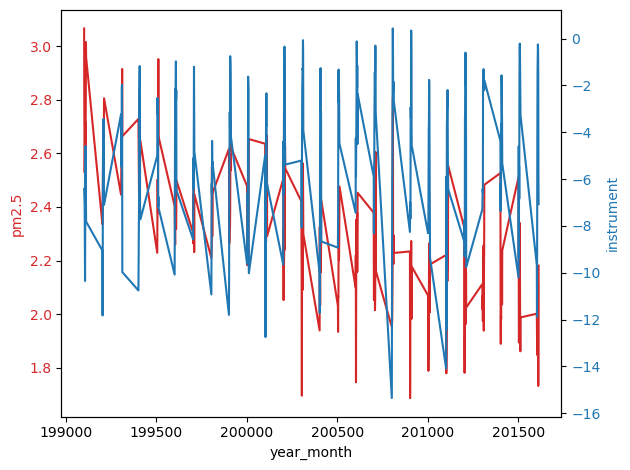

In [153]:
t=avg_ins[avg_ins['ins_4_add_acres_norms'] > 0].index
data1 = avg_ins[avg_ins['ins_4_add_acres_norms'] > 0]['zip_pm25']
data2 = avg_ins[avg_ins['ins_4_add_acres_norms'] > 0]['ins_4_add_acres_norms']

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('year_month')
ax1.set_ylabel('pm2.5', color=color)
ax1.plot(t, np.log(data1), color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('instrument', color=color)  # we already handled the x-label with ax1
ax2.plot(t, np.log(data2), color=color)
ax2.tick_params(axis='y', labelcolor=color)
52623
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [155]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import r2_score

In [158]:
for ins in instruments:
    X, y = create_stage1_data(instrument_var_name=ins)
    model = LinearRegression().fit(X,y)
    y_pred = model.predict(X)
    r2 = (r2_score(y,y_pred))
    adj_r2 = ((1-r2)*(X.shape[0]-1) / (X.shape[0] - X.shape[1] - 1))
    print('Instrument :',ins) 
    print('Adjusted R2:', adj_r2)
    print('Standard R2:', r2)

Instrument : ins_1_no_bin_raw
Adjusted R2: 0.32933926579149203
Standard R2: 0.6716489204737819
Instrument : ins_2_add_acres_raw
Adjusted R2: 0.3275699157168547
Standard R2: 0.6734129615931144
Instrument : ins_3_norms
Adjusted R2: 0.32938191577897946
Standard R2: 0.6716063984580738
Instrument : ins_4_add_acres_norms
Adjusted R2: 0.3286021371444722
Standard R2: 0.6723838373577951
Instrument : ins_5_norm_bins_acres
Adjusted R2: 0.3286413838715176
Standard R2: 0.6723447083910068
Instrument : ins_6_bins_raw
Adjusted R2: 0.3275307421178594
Standard R2: 0.6734520176512742


In [ ]:
temp_df = pd.DataFrame({'predictions' : y_pred,'year_month':df['year_month'],'pm25':df['zip_pm25']})
df2 = temp_df.groupby('year_month').mean()

In [ ]:
t=df2.index
data1 = df2['pm25']
data2 = df2['predictions']

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('year_month')
ax1.set_ylabel('pm 2.5 content', color=color)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

color = 'tab:blue'
ax1.plot(t, data2, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_title(f'LinearRegression() model predictions vs actual PM2.5 - {instrument}')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()